## **Model with feature engineering**

In [1]:
import pandas as pd
from pathlib import Path

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from bike_demand_forecasting.utils import get_paths

In [2]:
# Retrieve Path
paths = get_paths()

DATA_DIR = paths["DATA_DIR"]
DATA_PROCESSED_DIR = DATA_DIR / "processed"

data_path = DATA_PROCESSED_DIR / "df_started_hourly_full.csv"

In [3]:
# Read data
df_hourly = pd.read_csv(data_path)
df_hourly["started_at"] = pd.to_datetime(df_hourly["started_at"])

In [4]:
df_hourly.shape

(17544, 9)

In [5]:
df_hourly.head()

,started_at,y,year,month,day,hour,dayofweek,is_weekend,dayofyear
0,2024-01-01 00:00:00,272,2024,1,1,0,0,0,1
1,2024-01-01 01:00:00,324,2024,1,1,1,0,0,1
2,2024-01-01 02:00:00,237,2024,1,1,2,0,0,1
3,2024-01-01 03:00:00,60,2024,1,1,3,0,0,1
4,2024-01-01 04:00:00,26,2024,1,1,4,0,0,1


In [6]:
from bike_demand_forecasting.features import add_holiday_feature_us, add_lag_features, add_rolling_features
from bike_demand_forecasting.utils import split_dev_test, separate_X_y

In [7]:
# Add bool columns for holidays
df_feat = add_holiday_feature_us(df_hourly, dt_col = "started_at")

In [8]:
# add lag features (24, 168)
df_feat = add_lag_features(df_feat, target_col="y", lags=(24, 168))

In [9]:
# add roll features (24, 168)
df_feat = add_rolling_features(df_feat, target_col="y", windows=(24, 168))

In [10]:
# Delete NaN value
df_feat = df_feat.dropna().reset_index(drop=True)

In [11]:
df_feat.shape

(17353, 16)

In [12]:
# Convert to in16 to increase pipeline speed
print(df_hourly["y"].max())

int_cols = df_hourly.select_dtypes("int64").columns
df_hourly[int_cols] = df_hourly[int_cols].astype("int16")

3180


In [13]:
# Separate Dataset : dev set (trainval) & test set
df_dev, df_test = split_dev_test(df_feat, test_pct = 0.2)

In [14]:
# Separate features and target 
X_dev, y_dev = separate_X_y(df_dev)
X_test, y_test = separate_X_y(df_test)

In [15]:
# Time-based cross-validation on the development set
tscv = TimeSeriesSplit(
    n_splits=5,
    test_size=24*30,  # 30 validation days
    gap=24*7,          # 7-day purge gap
)

In [16]:
# Basic integrity checks for train/test splits
assert len(X_dev) == len(y_dev)
assert len(X_test) == len(y_test)

# Temporal split check: development data must be strictly earlier than test data
assert X_dev["started_at"].max() < X_test["started_at"].min()

# No timestamp overlap between development and test sets
assert set(X_dev["started_at"]).isdisjoint(set(X_test["started_at"]))

In [17]:
# Grid search parmaeteres
param_grid = {
    "reg__n_estimators": [200, 400],
    "reg__max_depth": [8, None],
    "reg__min_samples_leaf": [1, 3],
}

In [18]:
# Pipeline
bool_cols = ["is_weekend", "is_holiday"]
num_cols = ["year", "hour", "dayofweek", "month", "dayofyear", "lag_24", "lag_168",
       "roll_mean_24", "roll_std_24", "roll_mean_168", "roll_std_168"]

preprocess = ColumnTransformer(
    transformers=[
        ("bin", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), bool_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

model = Pipeline([
    ("prep", preprocess),
    ("reg", RandomForestRegressor(random_state=42))
])

In [19]:
from sklearn.metrics import make_scorer
from bike_demand_forecasting.metrics import smape, bias

scoring = {
    "mae": "neg_mean_absolute_error",
    "mape": "neg_mean_absolute_percentage_error",
    "smape": make_scorer(smape, greater_is_better=False),
    "bias": make_scorer(bias, greater_is_better=False)
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring=scoring,
    refit="mae",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_dev, y_dev)

# Final hold-out evaluation
best_model = grid.best_estimator_


best_model

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,steps,"[('prep', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bin', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


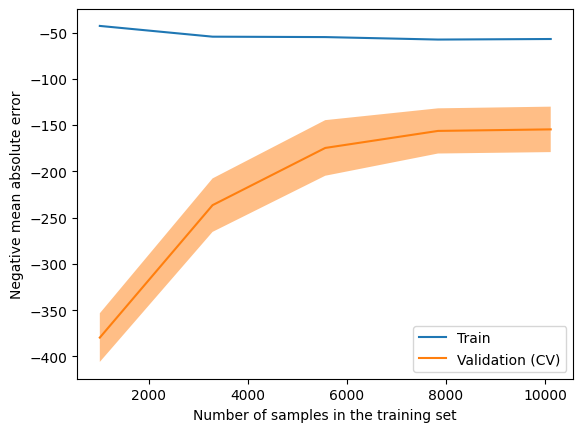

In [20]:
from sklearn.model_selection import LearningCurveDisplay
import matplotlib.pyplot as plt

disp = LearningCurveDisplay.from_estimator(
    grid.best_estimator_,
    X_dev, y_dev,
    cv=tscv,
    scoring="neg_mean_absolute_error"
)

# Rename legend labels
disp.ax_.lines[0].set_label("Train")
disp.ax_.lines[1].set_label("Validation (CV)")
disp.ax_.legend()
plt.show()

In [21]:
import joblib

WORK_DIR = paths["WORK_DIR"]

model_dir = WORK_DIR / "models"

# Save models
joblib.dump(best_model, model_dir / "rfg_feature_eng.joblib")
joblib.dump(grid, model_dir / "rfg_feature_eng_grid.joblib")

['/mnt/c/Users/33760/Desktop/bike-demand-forecasting/models/rfg_feature_eng_grid.joblib']

In [22]:
DATA_PROCESSED_DIR = DATA_DIR / "processed"

# Save the test set & label to data/processed 
X_test.to_csv(DATA_PROCESSED_DIR / "X_test_feat_eng.csv", index=False)